# DSC550-T301 Data Mining
## Week 7: 7.2 Exercise: Dimensionality Reduction and Feature Selection / Daniel Solis Toro

## Part 1: PCA and Variance Threshold in a Linear Regression

In [85]:
# Import libraries 
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

### 1. Load the housing data 

In [87]:
housing = pd.read_csv('train.csv')
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 2. Drop Id and columns with >40% missing values

In [89]:
housing = housing.drop(columns=['Id'])
missing_ratio = housing.isna().mean()
housing = housing.loc[:, missing_ratio <= 0.4]

### 3–4. Handle missing values

In [91]:
num_cols = housing.select_dtypes(include=np.number).columns
cat_cols = housing.select_dtypes(exclude=np.number).columns


for col in num_cols:
    housing[col] = housing[col].fillna(housing[col].median())


for col in cat_cols:
    housing[col] = housing[col].fillna(housing[col].mode()[0])

### 5. Convert categorical columns to dummies

In [93]:
housing_dummies = pd.get_dummies(housing, drop_first=True)

### 6. Train-test split

In [95]:
X = housing_dummies.drop(columns=['SalePrice'])
y = housing_dummies['SalePrice']


X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42
)

### 7. Linear Regression (baseline)

In [97]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)


y_pred = lin_reg.predict(X_test)


r2_baseline = r2_score(y_test, y_pred)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred))


r2_baseline, rmse_baseline

(0.6478367401194067, 51973.13807603468)

### 8. PCA retaining 90% variance

In [99]:
pca = PCA(n_components=0.90, random_state=42)
X_train_pca = pca.fit_transform(X_train)

### 9. Number of PCA features

In [101]:
X_train_pca.shape[1]

1

### 10. Transform test set (no fitting)

In [103]:
X_test_pca = pca.transform(X_test)

### 11. Linear Regression with PCA data

In [105]:
lin_reg_pca = LinearRegression()
lin_reg_pca.fit(X_train_pca, y_train)


y_pred_pca = lin_reg_pca.predict(X_test_pca)


r2_pca = r2_score(y_test, y_pred_pca)
rmse_pca = np.sqrt(mean_squared_error(y_test, y_pred_pca))


r2_pca, rmse_pca

(0.06348978213632561, 84754.58021474867)

### 12. Min-Max scaling

In [107]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

### 13. Variance Threshold (> 0.1)

In [109]:
var_thresh = VarianceThreshold(threshold=0.1)
X_train_highvar = var_thresh.fit_transform(X_train_scaled)


X_train_highvar.shape

(1168, 40)

### 14. Transform test set

In [111]:
X_test_scaled = scaler.transform(X_test)
X_test_highvar = var_thresh.transform(X_test_scaled)

### 15. Linear Regression with high-variance features

In [113]:
lin_reg_var = LinearRegression()
lin_reg_var.fit(X_train_highvar, y_train)


y_pred_var = lin_reg_var.predict(X_test_highvar)


r2_var = r2_score(y_test, y_pred_var)
rmse_var = np.sqrt(mean_squared_error(y_test, y_pred_var))


r2_var, rmse_var

(0.648122941134226, 51952.01465127289)

### 16. Summary Part 1

In [115]:
summary_part1 = pd.DataFrame({
'Model': ['Baseline', 'PCA (90% var)', 'High Variance (>0.1)'],
'R2': [r2_baseline, r2_pca, r2_var],
'RMSE': [rmse_baseline, rmse_pca, rmse_var]
})


summary_part1

,Model,R2,RMSE
0,Baseline,0.647837,51973.138076
1,PCA (90% var),0.063490,84754.580215
2,High Variance (>0.1),0.648123,51952.014651


- Baseline: The baseline linear regression explains about 65% of the variance in housing prices and provides a strong reference performance.

- PCA (90% var): Retaining 90% of feature variance with PCA severely reduced predictive power, showing that variance does not necessarily align with target relevance.

- High Variance (>0.1): Removing low-variance features slightly improved performance over the baseline while reducing model complexity.

### Part 2: Categorical Feature Selection (Mushroom Dataset)

In [117]:
# Import libraries 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt

### 1. Load mushroom data

In [119]:
mushrooms = pd.read_csv('mushrooms.csv')
mushrooms.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


### 2. Dummy encoding

In [121]:
mushrooms_dummies = pd.get_dummies(mushrooms, drop_first=True)


X = mushrooms_dummies.drop(columns=['class_p'])
y = mushrooms_dummies['class_p']

### 3. Train-test split

In [123]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42
)

### 4. Decision Tree Classifier

In [125]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### 5. Accuracy and confusion matrix

In [127]:
y_pred = dt.predict(X_test)


acc_full = accuracy_score(y_test, y_pred)
cm_full = confusion_matrix(y_test, y_pred)


acc_full, cm_full

(1.0,
 array([[843,   0],
        [  0, 782]], dtype=int64))

### 6. Visualize decision tree

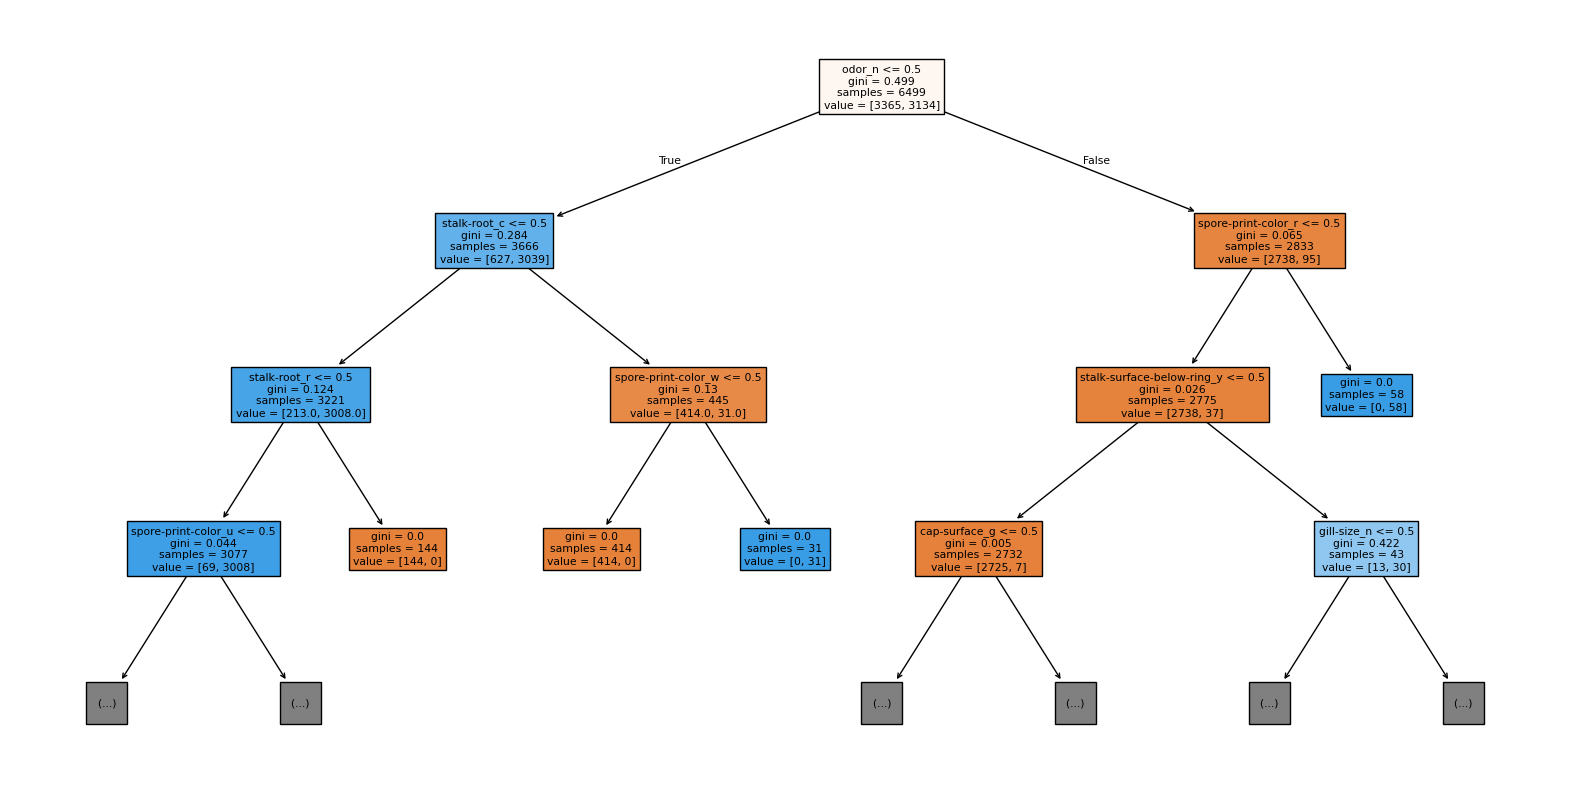

In [129]:
plt.figure(figsize=(20,10))
plot_tree(dt, max_depth=3, feature_names=X.columns, filled=True)
plt.show()

### 7. Chi-square feature selection (top 5)

In [131]:
selector = SelectKBest(score_func=chi2, k=5)
X_train_chi = selector.fit_transform(X_train, y_train)


selected_features = X_train.columns[selector.get_support()]
selected_features

Index(['odor_f', 'odor_n', 'gill-size_n', 'stalk-surface-above-ring_k',
       'stalk-surface-below-ring_k'],
      dtype='object')

### 8 Features selected in step 7:
- 'odor_f'
- 'odor_n'
- 'gill-size_n'
- 'stalk-surface-above-ring_k'
- 'stalk-surface-below-ring_k'

### 9. Decision Tree with selected features

In [133]:
X_test_chi = selector.transform(X_test)


dt_chi = DecisionTreeClassifier(random_state=42)
dt_chi.fit(X_train_chi, y_train)


y_pred_chi = dt_chi.predict(X_test_chi)


acc_chi = accuracy_score(y_test, y_pred_chi)
cm_chi = confusion_matrix(y_test, y_pred_chi)


acc_chi, cm_chi

(0.9735384615384616,
 array([[816,  27],
        [ 16, 766]], dtype=int64))

### 10. Summary Part 2

In [135]:
summary_part2 = pd.DataFrame({
'Model': ['All Features', 'Top 5 Chi-Square Features'],
'Accuracy': [acc_full, acc_chi]
})


summary_part2

,Model,Accuracy
0,All Features,1.000000
1,Top 5 Chi-Square Features,0.973538


- All Features: The decision tree achieved perfect accuracy, indicating that the full feature set provides complete separability for this dataset.
- Top 5 Chi-Square Features: Using only the five most informative features resulted in a small drop in accuracy while retaining strong predictive performance with a simpler model.